<a href="https://colab.research.google.com/github/Farmhouse121/Financial-Data-Science-in-Python/blob/main/Miscellaneous/S%26P_500_Pairwise_Correlations.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from my_library import *

14:29:33 Starting...
14:29:33 Installing yfinance into Google notebook...
14:29:40 Installing arch into Google notebook...
14:29:50 Initialized.


In [2]:
display(sp500:=pd.read_html('https://en.wikipedia.org/wiki/List_of_S%26P_500_companies')[0])

,Symbol,Security,GICS Sector,GICS Sub-Industry,Headquarters Location,Date added,CIK,Founded
0,MMM,3M,Industrials,Industrial Conglomerates,"Saint Paul, Minnesota",1957-03-04,66740,1902
1,AOS,A. O. Smith,Industrials,Building Products,"Milwaukee, Wisconsin",2017-07-26,91142,1916
2,ABT,Abbott Laboratories,Health Care,Health Care Equipment,"North Chicago, Illinois",1957-03-04,1800,1888
3,ABBV,AbbVie,Health Care,Biotechnology,"North Chicago, Illinois",2012-12-31,1551152,2013 (1888)
4,ACN,Accenture,Information Technology,IT Consulting & Other Services,"Dublin, Ireland",2011-07-06,1467373,1989
...,...,...,...,...,...,...,...,...
498,XYL,Xylem Inc.,Industrials,Industrial Machinery & Supplies & Components,"White Plains, New York",2011-11-01,1524472,2011
499,YUM,Yum! Brands,Consumer Discretionary,Restaurants,"Louisville, Kentucky",1997-10-06,1041061,1997
500,ZBRA,Zebra Technologies,Information Technology,Electronic Equipment & Instruments,"Lincolnshire, Illinois",2019-12-23,877212,1969
501,ZBH,Zimmer Biomet,Health Care,Health Care Equipment,"Warsaw, Indiana",2001-08-07,1136869,1927


In [3]:
results=pd.DataFrame({"Sample":list(range(N:=10))}).set_index("Sample")

for i in results.index:
    df=download(list(sp500.sample(2,axis=0)['Symbol'])).dropna()

    if df.shape[0]<10:
        continue

    for ticker in (tickers:=list(set(df.columns.get_level_values(1)))):
        df[('Return',ticker)]=df[('Adj Close',ticker)].pct_change()*hundred

    df.dropna(inplace=True)
    df.index=pd.DatetimeIndex(df.index).to_period('D')

    for j in range(2):
        results.loc[i,j]=tickers[j]

    results.loc[i,"Correlation"]=df.corr().iloc[0,1]*hundred
    results.loc[i,"Sample"]=df.shape[0]

results.set_index([0,1],inplace=True)
results.index.names=["Ticker 1","Ticker 2"]
results.loc["Mean","Sample"]=results.shape[0]
results.loc["Mean","Correlation"]=results["Correlation"].mean()
display(results)

[*********************100%***********************]  2 of 2 completed
<ipython-input-3-0cf24419926c>:13: UserWarning: Converting to PeriodArray/Index representation will drop timezone information.
  df.index=pd.DatetimeIndex(df.index).to_period('D')
[*********************100%***********************]  2 of 2 completed
<ipython-input-3-0cf24419926c>:13: UserWarning: Converting to PeriodArray/Index representation will drop timezone information.
  df.index=pd.DatetimeIndex(df.index).to_period('D')
[*********************100%***********************]  2 of 2 completed
<ipython-input-3-0cf24419926c>:13: UserWarning: Converting to PeriodArray/Index representation will drop timezone information.
  df.index=pd.DatetimeIndex(df.index).to_period('D')
[*********************100%***********************]  2 of 2 completed
<ipython-input-3-0cf24419926c>:13: UserWarning: Converting to PeriodArray/Index representation will drop timezone information.
  df.index=pd.DatetimeIndex(df.index).to_period('D')
[***

,,Correlation,Sample
Ticker 1,Ticker 2,,
REGN,MTB,84.021350,8416.0
REG,PEP,89.622653,7762.0
MDT,IRM,76.033411,7192.0
ZBRA,MO,75.593826,8321.0
DVN,SNA,47.254863,9855.0
MAR,VZ,83.116445,6653.0
WBA,COST,41.468087,9612.0
EIX,PPG,95.258174,11207.0
POOL,CMG,88.899628,4678.0


In [76]:
from warnings import filterwarnings

for warning in UserWarning,FutureWarning:
    filterwarnings("ignore",category=warning)

first_date=sp500['Date added'].max()
results=pd.DataFrame({"Sample":range(1,(n:=50)+1),"Assets":[np.nan]*n,"Portfolio":[np.nan]*n}).set_index("Sample")

for i in tqdm(results.index):
    closes=pd.DataFrame(download(stocks:=[t for t in sp500.sample(np.random.randint(1,sp500.shape[0]),axis=0)['Symbol'] if '.B' not in t],first_date)['Adj Close']) # wrap w/DataFrame in case Series
    closes.index=pd.DatetimeIndex(closes.index).to_period('B')

    returns=pd.DataFrame()

    for ticker in closes.columns:
        returns[ticker]=closes[ticker].pct_change().dropna()*hundred

        if returns[ticker].shape[0]<1: # exclude all NA time-series
            returns.drop(columns=ticker,inplace=True)

        else:
            returns=returns.copy() # 'cos it frags, apparently

    results.loc[i,"Independent"]=returns.var().sum()/results.loc[i,"Assets"]**2
    returns['Portfolio']=returns.mean(axis=1)
    results.loc[i,"Assets"]=returns.shape[1]-1
    results.loc[i,"Portfolio"]=returns['Portfolio'].var()

results.dropna(inplace=True)
results["Effective D.o.F."]=results["Independent"]/results["Portfolio"]*results["Assets"]
display(results)

  0%|          | 0/50 [00:00<?, ?it/s]

[*********************100%***********************]  484 of 484 completed
[*********************100%***********************]  96 of 96 completed
[*********************100%***********************]  192 of 192 completed
[*********************100%***********************]  434 of 434 completed
[*********************100%***********************]  404 of 404 completed
[*********************100%***********************]  87 of 87 completed
[*********************100%***********************]  25 of 25 completed
[*********************100%***********************]  234 of 234 completed
[*********************100%***********************]  89 of 89 completed
[*********************100%***********************]  66 of 66 completed
[*********************100%***********************]  48 of 48 completed
[*********************100%***********************]  273 of 273 completed
[*********************100%***********************]  107 of 107 completed
[*********************100%***********************]  28 of 28 co

,Assets,Portfolio,Independent,Effective D.o.F.
Sample,,,,
1,484.0,0.923849,0.009342,4.894408
2,96.0,0.932488,0.043614,4.490060
3,192.0,0.960391,0.022652,4.528542
4,434.0,0.941054,0.010563,4.871297
5,404.0,0.893432,0.011099,5.018898
6,87.0,0.921293,0.050467,4.765684
7,25.0,0.858098,0.133487,3.889052
8,234.0,0.890363,0.019101,5.020090
9,89.0,1.071844,0.054082,4.490672


Text(0.5, 1.0, 'Daily Returns Squared, 2024-07-08 to 2024-08-29')

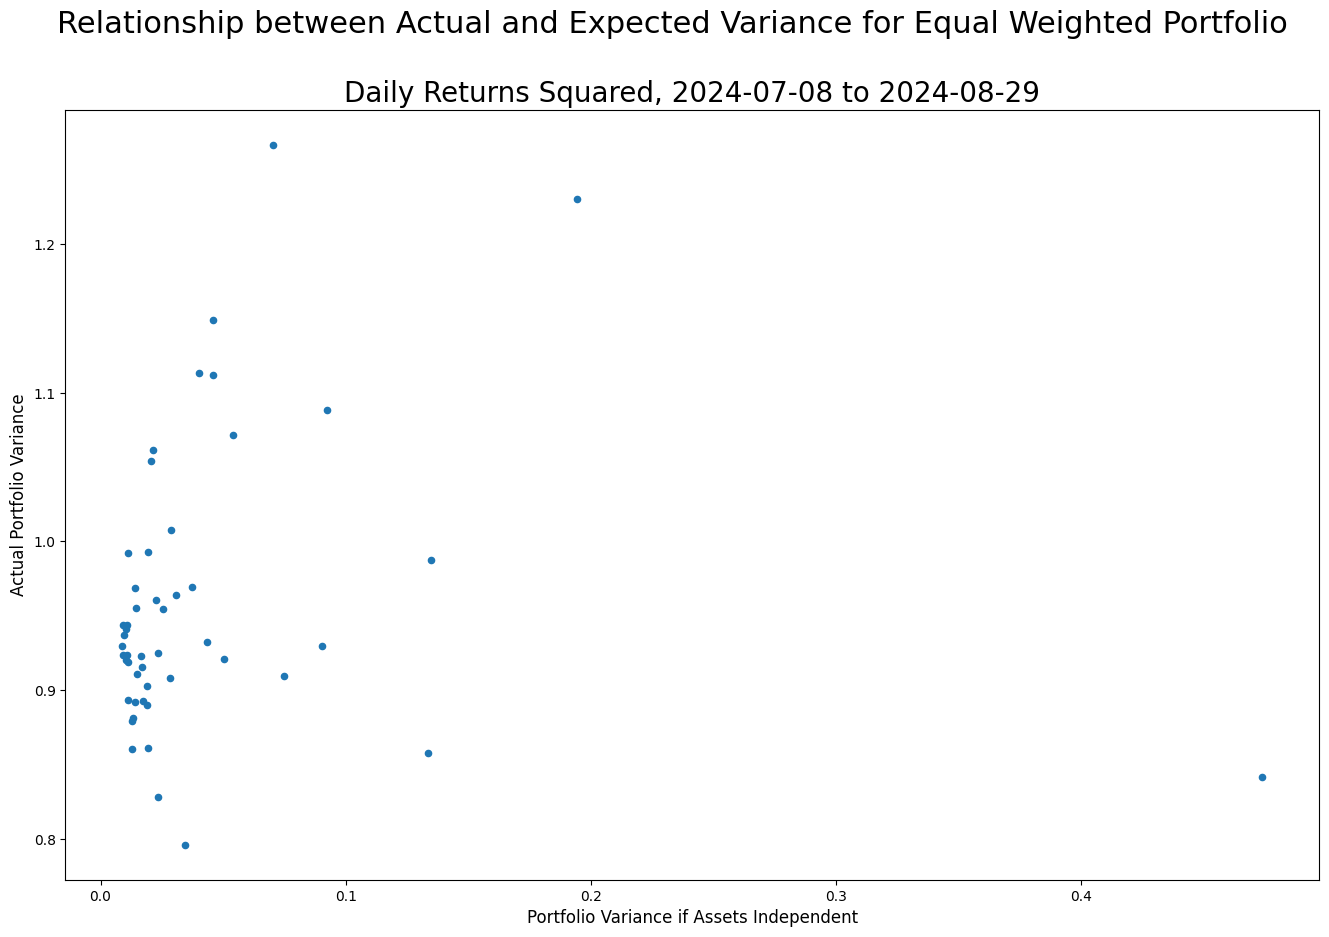

In [77]:
figure,plot=pl.subplots(figsize=(ten*GoldenRatio,ten))
results.plot.scatter(x:="Independent",y:="Portfolio",ax=plot)
plot.set_xlabel("Portfolio Variance if Assets Independent",fontsize=12)
plot.set_ylabel("Actual Portfolio Variance",fontsize=12)
figure.suptitle(title:="Relationship between Actual and Expected Variance for Equal Weighted Portfolio",fontsize=22)
plot.set_title("Daily Returns Squared, %s to %s" % (first_date,pd.Timestamp.today().strftime("%Y-%m-%d")),fontsize=20)


Text(0.5, 1.0, 'Daily Returns Squared, 2024-07-08 to 2024-08-29')

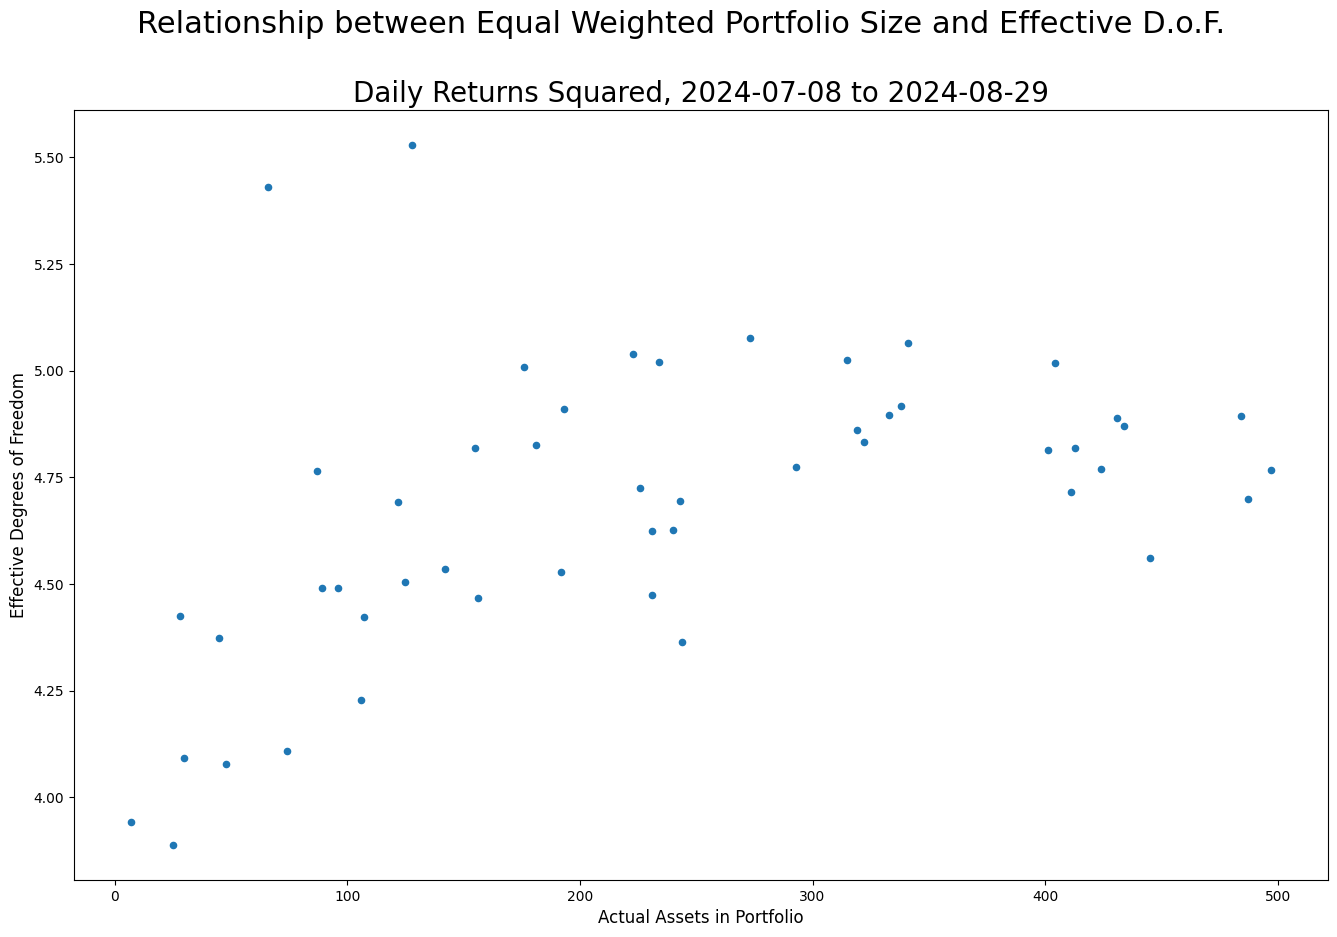

In [78]:
figure,plot=pl.subplots(figsize=(ten*GoldenRatio,ten))
results.plot.scatter(x:="Assets",y:="Effective D.o.F.",ax=plot)
plot.set_xlabel("Actual Assets in Portfolio",fontsize=12)
plot.set_ylabel("Effective Degrees of Freedom",fontsize=12)
figure.suptitle(title:="Relationship between Equal Weighted Portfolio Size and Effective D.o.F.",fontsize=22)
plot.set_title("Daily Returns Squared, %s to %s" % (first_date,pd.Timestamp.today().strftime("%Y-%m-%d")),fontsize=20)

In [79]:
returns

,A,AAL,AAPL,ADI,AEE,AES,AFL,ALLE,AMCR,AMD,...,VZ,WDC,WELL,WM,WST,WY,XEL,XOM,ZBRA,Portfolio
Date,,,,,,,,,,,,,,,,,,,,,
2024-07-09,-0.515588,0.457450,0.377485,-0.569985,0.919250,-0.952381,0.463176,-0.321630,-0.726892,-0.889807,...,-0.553815,-0.089172,0.392649,-0.284869,-0.421903,-0.072492,0.690847,-1.105364,0.241662,-0.107068
2024-07-10,1.315581,1.548270,1.880358,2.724024,0.630601,1.357465,1.439333,2.031919,1.987443,3.873518,...,-0.532681,2.307787,-0.267098,0.552323,0.853655,0.036272,0.228700,0.883357,2.718566,0.917658
2024-07-11,2.951135,-3.766817,-2.322083,-1.925900,1.824266,4.073658,2.449838,2.418805,0.615389,-1.098067,...,0.535534,-2.991029,0.095647,0.279388,3.718681,5.003623,2.833241,1.188350,1.392795,1.219449
2024-07-12,1.077808,-0.465976,1.305087,2.062117,1.039380,1.286862,0.238045,2.586997,1.019362,-0.181379,...,0.314773,1.194759,-0.430009,0.934975,-3.096303,1.104978,0.369817,0.017657,-0.953340,0.838444
2024-07-15,-0.922636,-0.468167,1.674330,-0.352111,-1.529504,-10.005291,0.788000,-0.170828,-0.706354,-0.980122,...,-1.544773,0.063480,1.094049,1.052632,-0.888608,-0.819671,-1.934413,1.712724,0.710353,0.088287
2024-07-16,3.854670,5.268104,0.179187,2.359919,1.621994,3.823527,0.192782,4.318777,2.337394,-1.267863,...,1.618043,-2.232939,0.569590,2.263889,2.811534,2.376028,1.315049,0.720425,2.522140,1.815731
2024-07-17,-1.881521,-1.608573,-2.529598,-3.172647,1.771943,-4.305950,0.545157,-0.859245,2.581929,-10.205582,...,1.399271,-6.838823,0.802339,1.100099,-0.628962,2.556341,2.577414,1.378834,-2.939598,-0.329260
2024-07-18,-1.146067,-3.542237,-2.053483,1.434576,-0.252518,1.124929,0.244528,0.386074,-0.096808,-2.295671,...,0.095172,-2.159079,-0.786594,-0.098514,-3.271775,-0.590358,0.831524,0.986062,-0.773273,-0.941911
2024-07-19,-0.143974,-0.376647,0.057991,-3.251184,-0.306467,0.117099,-1.463567,-2.597916,-2.034884,-2.689865,...,-1.069648,-0.597947,1.378015,-0.134470,0.499468,-0.560871,0.286841,-2.297983,-0.593742,-0.650454


In [80]:
returns.var()

,0
A,2.422210
AAL,7.255469
AAPL,2.241788
ADI,7.590310
AEE,1.161996
...,...
WY,2.720957
XEL,1.567921
XOM,1.764581
ZBRA,3.891363
